In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax as jx
import jax.numpy as jnp
from jax.example_libraries import optimizers
from functools import partial

from tqdm import tqdm

key = jx.random.PRNGKey(0)

In [2]:
def init_params(layers, key):
  # Glorot initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))    
    # key, subkey = jx.random.split(key)
    # bs.append(jx.random.normal(subkey, (layers[i + 1],))*std_glorot)
  return [Ws, bs]

@jx.jit
def forward_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jx.nn.relu(H)**2
    # H = jnp.tanh(H)
  Y = jnp.matmul(H, Ws[-1]) + bs[-1]
  return Y

@jx.jit
def forward_grad_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = Ws[i]*jx.nn.relu(H)*2
    # H = jnp.tanh(H)
  Y = jnp.matmul(H, Ws[-1])
  return Y

def create_grads():
  fp_wrapper = lambda x, params: forward_pass(x, params)[0]
  du_dx = jx.grad(fp_wrapper)
  du_dx_wrapper = lambda x, params: du_dx(x, params)[0]
  dU_dx = jx.vmap(du_dx,in_axes=(0,None), out_axes=0)
  dU_dxx = jx.vmap(jx.grad(du_dx_wrapper),in_axes=(0,None), out_axes=0)
  return dU_dx, dU_dxx

grad_X, grad_XX = create_grads()

@partial(jx.jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    # Optimizer step
    params = get_params(opt_state)
    g = jx.grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, loss2, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000, stop=1e-5):
    train_loss = []
    val_loss = []
    key = jx.random.PRNGKey(0)
    for it in (pbar := tqdm(range(nIter))):
        opt_state = step(loss, it, opt_state, X, Y)
        if it % 50 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            pbar.set_description(f"{to_print}")
            if train_loss_value<stop:break
    return get_params(opt_state), train_loss, val_loss

@jx.jit
def one_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jx.nn.relu(H)**2
    # H = jnp.tanh(H)
  return H

@jx.jit
def one_grad_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = Ws[i]*jx.nn.relu(H)*2
    # H = jnp.tanh(H)
  return H

def train_ls(loss, loss2, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000, stop=1e-5):
    train_loss = []
    val_loss = []
    key = jx.random.PRNGKey(0)
    for it in (pbar := tqdm(range(nIter))):
        opt_state = step(loss, it, opt_state, X, Y)
        params = get_params(opt_state)

        # res_last = one_pass(X, params)
        res_last = one_grad_pass(X, params)
        vec_ext = res_last
        # vec_ext = jnp.c_[res_last, 1+0*res_last[:,0]]
        ls = (jnp.linalg.pinv(vec_ext)@Y)

        params[0][-1] = ls
        params[1][-1] = 0.#ls[-1:]
        opt_state = opt_init(params)

        if it % 50 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            pbar.set_description(f"{to_print}")
            if train_loss_value<stop:break
    return get_params(opt_state), train_loss, val_loss


def train_ls_auto(loss, loss2, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000, stop=1e-5):
    train_loss = []
    val_loss = []
    key = jx.random.PRNGKey(0)
    for it in (pbar := tqdm(range(nIter))):
        opt_state = step(loss, it, opt_state, X, Y)
        params = get_params(opt_state)
        last_homo = one_grad_pass(X, params)
        s_init = jnp.c_[params[0][-1].T, params[1][-1]]
        s_init = s_init[0,:][:-1]
        gL2 = jx.grad(loss2)
        B = gL2(s_init*0, last_homo, Y)
        ggL2 = jx.jacfwd(gL2)
        A = 0.5*ggL2(s_init*0, last_homo, Y)
        s_fin = -0.5*jnp.linalg.pinv(A)@B
        params[0][-1] = s_fin[:,None]
        params[1][-1] = s_fin[-1:][:,None]
        
        opt_state = opt_init(params)

        if it % 50 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            pbar.set_description(f"{to_print}")
            if train_loss_value<stop:break
    return get_params(opt_state), train_loss, val_loss



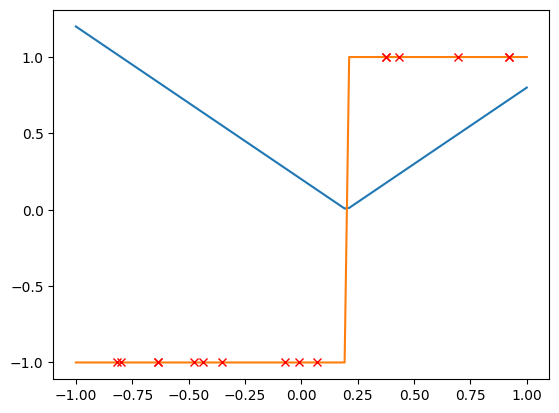

In [55]:
X = np.linspace(-1, 1, 100)[:, None]
# Y = 1/(X**2-1.1)#np.cos(8.*X*np.pi)*np.exp(-8*X)
# Y /= Y.max()
# Y = np.sin(5*X)
X0 = 0.2
# intY = np.sin(5*X)
# Y = 5*np.cos(5*X)
intY = np.linalg.norm(X-X0, axis=1)
Y = (X<X0)*-1+(X>=X0)*1
# intY = X*0+1
# Y = X*0

rng_agent = np.random.default_rng(6516)
train_samples = rng_agent.choice(X.shape[0], 16)
X_train = X[train_samples]
Y_train = Y[train_samples]

plt.plot(X, intY)
plt.plot(X, Y)
plt.plot(X_train, Y_train, "rx")
plt.show()

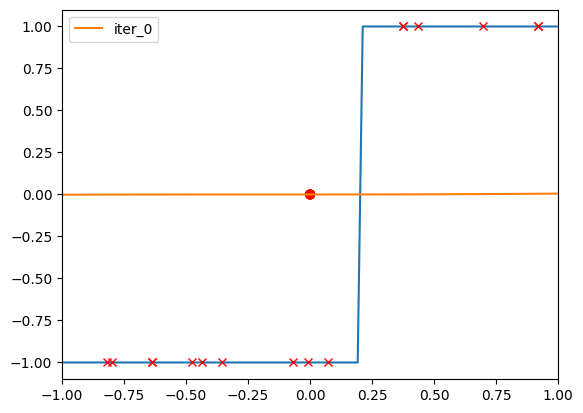

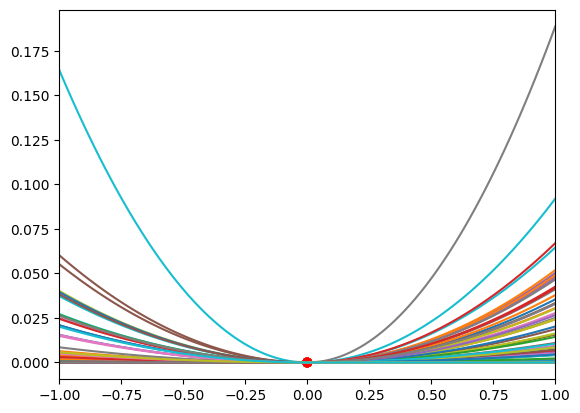

it 950, train loss = 1.525504e-02: 100%|████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.15it/s]


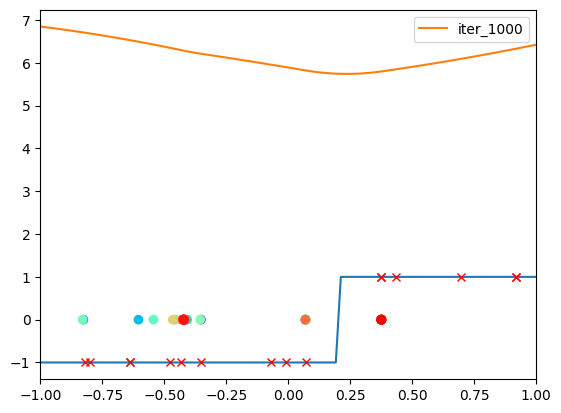

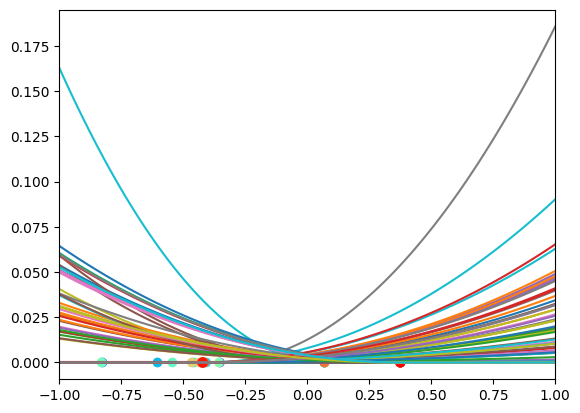

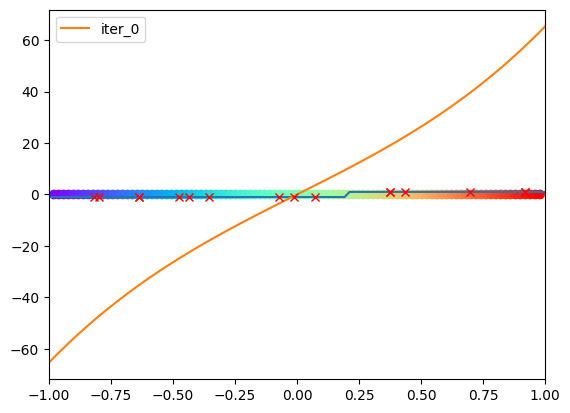

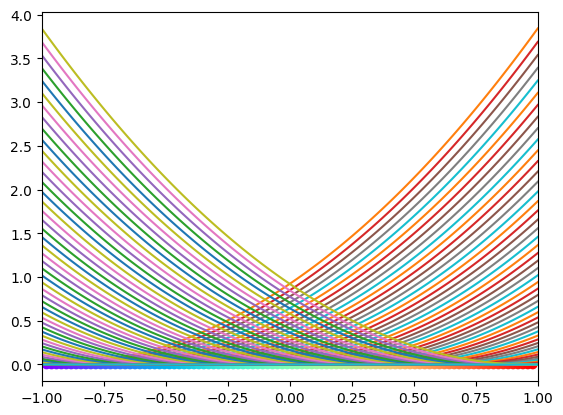

it 950, train loss = 5.059615e-06: 100%|████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.15it/s]


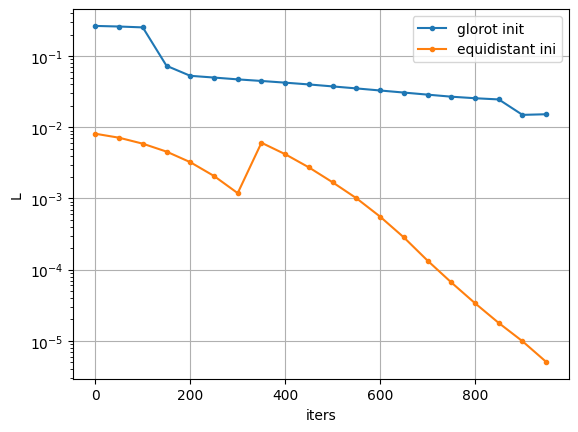

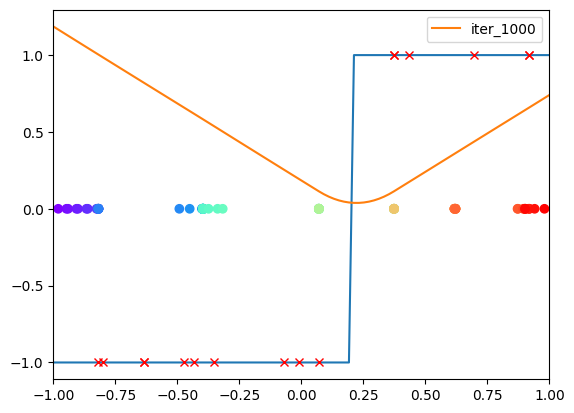

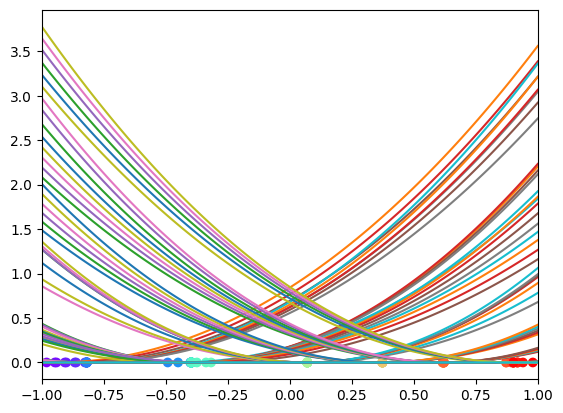

In [56]:
layers = [1] + [100]*1 + [1]
nIter = 1000
lr = 1e-4
stop_at = 1e-15

key = jx.random.PRNGKey(0)
def init_params_modi(layers, key):
  # Glorot initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    c = jnp.linspace(-1, 1, layers[i + 1]+2)[1:-1]
    # Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    # Ws.append(jnp.sign(jx.random.normal(subkey, (layers[i], layers[i + 1]))))
    # W = jx.random.normal(subkey, (layers[i], layers[i + 1]))+1
    W = np.ones((layers[i], layers[i + 1]))
    # W = np.array(W)
    W[::2,::2]*=-1

    Ws.append(W)  
    bs.append(-W[0]*c)
  return [Ws, bs]

params_glorot = init_params(layers, key)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params_glorot)
def plt_state(params, lbl):
  W0, b0 = params
  W0 = W0[0]
  b0 = b0[0]
  plt.plot(X, Y)
  plt.plot(X, forward_pass(X, params), label=lbl)
  plt.plot(X_train, Y_train, "rx")
  plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
  plt.xlim(-1, 1)
  plt.legend()
  plt.show()

  plt.plot(X, jx.nn.relu(X@W0+b0)**2)
  plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
  plt.xlim(-1, 1)
  plt.show()

plt_state(params_glorot, "iter_0")

@jx.jit
def loss(params, X, Y):
    # Y_pred = forward_pass(X, params)
    # MSE = jnp.mean((Y_pred-Y)**2)
    # g = du_dx(X, params)
    g = forward_grad_pass(X, params)

    MSE = jnp.mean((g-Y)**2)
    return  MSE

@jx.jit
def loss_2(s, layer_output, Y):
    Y_pred = layer_output@s
    MSE = jnp.mean((Y_pred[:,None]-Y)**2)
    return  MSE

# params, train_loss, val_loss = train(loss, X_train, Y_train, None, opt_state, nIter = nIter)
params_glorot, train_loss, val_loss = train_ls_auto(loss, loss_2, X_train, Y_train, None, opt_state, nIter = nIter, stop=stop_at)
opt_state = opt_init(params_glorot)

plt_state(params_glorot, f"iter_{nIter}")

#modified init

params = init_params_modi(layers, key)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)

plt_state(params, "iter_0")

# params, train_loss, val_loss = train(loss, X_train, Y_train, None, opt_state, nIter = nIter)
params, train_loss2, val_loss2 = train_ls_auto(loss, loss_2, X_train, Y_train, None, opt_state, nIter = nIter, stop=stop_at)
opt_state = opt_init(params)

plt.semilogy()
plt.plot(np.arange(len(train_loss))*50, train_loss, ".-", label="glorot init")
plt.plot(np.arange(len(train_loss2))*50, train_loss2, ".-", label="equidistant ini")
plt.ylabel("L")
plt.xlabel("iters")
plt.legend()
plt.grid()
plt.show()

plt_state(params, f"iter_{nIter}")

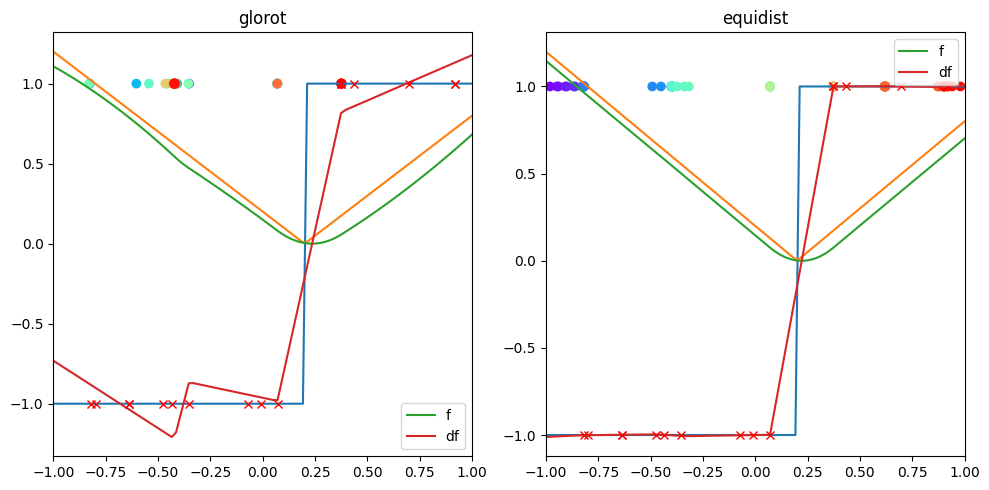

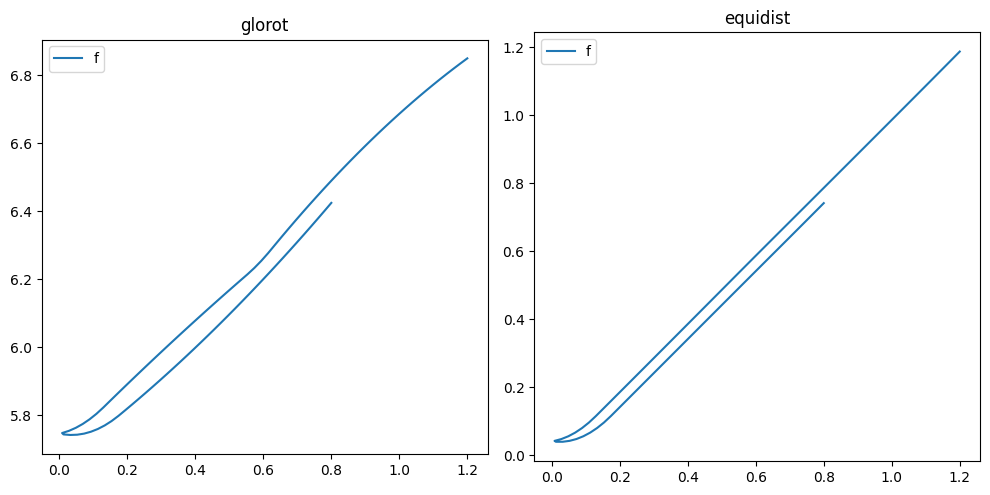

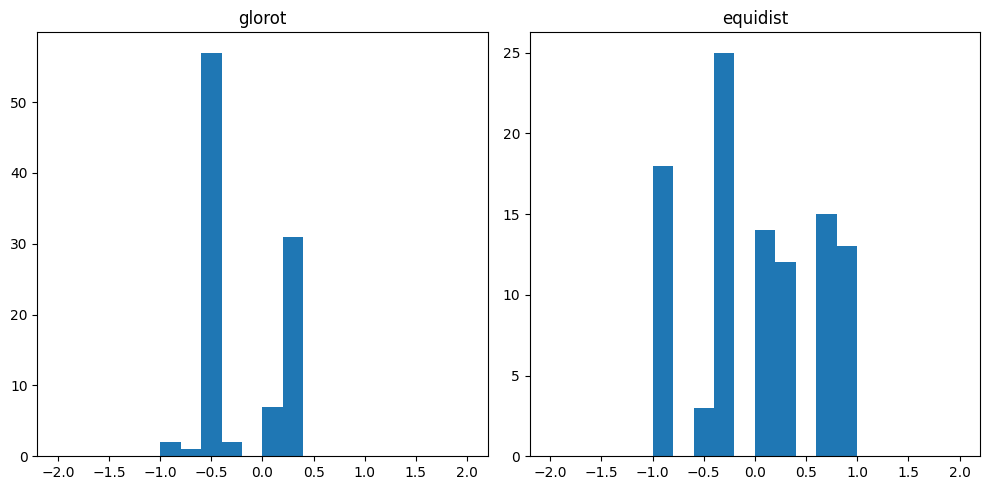

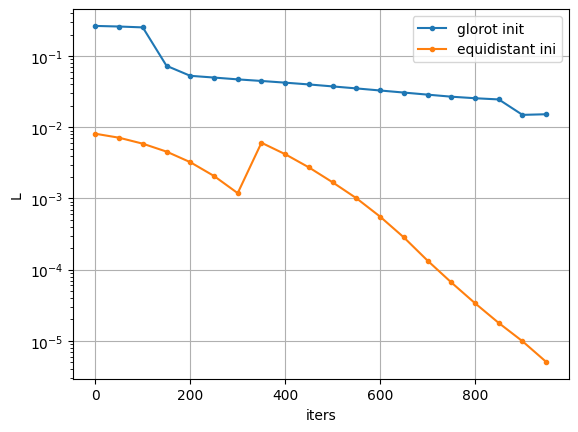

In [65]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].plot(X, Y)
ax[0].plot(X, intY)
ax[0].plot(X, forward_pass(X, params_glorot)-forward_pass(X, params_glorot).min(), label="f")
ax[0].plot(X, forward_grad_pass(X, params_glorot), label="df")
ax[0].plot(X_train, Y_train, "rx")
ax[0].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[0].set_xlim(-1, 1)
ax[0].legend()
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].plot(X, Y)
ax[1].plot(X, intY)
ax[1].plot(X, forward_pass(X, params)-forward_pass(X, params).min(), label="f")
ax[1].plot(X, forward_grad_pass(X, params), label="df")
ax[1].plot(X_train, Y_train, "rx")
ax[1].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[1].set_xlim(-1, 1)
ax[1].legend()
ax[0].set_title("glorot")
ax[1].set_title("equidist")
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
ax[0].plot(intY, forward_pass(X, params_glorot), label="f")
ax[0].legend()
ax[1].plot(intY, forward_pass(X, params), label="f")
ax[1].legend()
ax[0].set_title("glorot")
ax[1].set_title("equidist")
ax[0].axis("scaled");ax[1].axis("scaled")
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].hist(-b0/W0[0], bins=np.linspace(-2,2,21))
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].hist(-b0/W0[0], bins=np.linspace(-2,2,21))
ax[0].set_title("glorot")
ax[1].set_title("equidist")
fig.tight_layout()
plt.show()

plt.semilogy()
plt.plot(np.arange(len(train_loss))*50, train_loss, ".-", label="glorot init")
plt.plot(np.arange(len(train_loss2))*50, train_loss2, ".-", label="equidistant ini")
plt.ylabel("L")
plt.xlabel("iters")
plt.legend()
plt.grid()
plt.show()

In [58]:
#normah1, relu cuadrada, relu

In [59]:
last = one_grad_pass(X_train, params)
last_homo = jnp.c_[last, 1+0*last[:,0]]
s_init = jnp.c_[params[0][-1].T, params[1][-1]]
s_init = s_init[0,:]
def loss_2(s, layer_output, Y):
    Y_pred = layer_output@s
    MSE = jnp.mean((Y_pred[:,None]-Y)**2)
    # MSE = jnp.linalg.norm(Y_pred[:,None]-Y)**2
    return  MSE
loss_2(s_init, last_homo, Y_train)

Array(2.793498e-06, dtype=float32)

In [60]:
A = (1/last_homo.shape[0])*last_homo.T@last_homo
B = -2*(1/last_homo.shape[0])*last_homo.T@Y_train
s_init.T@A@s_init + B.T@s_init + jnp.mean(Y_train**2)

Array([2.8014183e-06], dtype=float32)

In [61]:
gL2 = jx.grad(loss_2)
B = gL2(s_init*0, last_homo, Y_train)
ggL2 = jx.jacfwd(gL2)
A = 0.5*ggL2(s_init*0, last_homo, Y_train)

s_init.T@A@s_init + B@s_init + jnp.mean(Y_train**2)

Array(2.5629997e-06, dtype=float32)

In [62]:
gL2 = jx.grad(loss_2)
B = gL2(s_init*0, last_homo, Y_train)
ggL2 = jx.jacfwd(gL2)
A = 0.5*ggL2(s_init*0, last_homo, Y_train)
s_fin = -0.5*jnp.linalg.inv(A+1e-5*jnp.eye(A.shape[0]))@B
s_fin = -0.5*jnp.linalg.pinv(A)@B
# s_fin = B
loss_2(s_fin, last_homo, Y_train), A.shape, s_fin.T@A@s_fin + B@s_fin + jnp.mean(Y_train**2)

(Array(2.7941362e-06, dtype=float32),
 (101, 101),
 Array(2.503395e-06, dtype=float32))

In [63]:
A = (1/last_homo.shape[0])*last_homo.T@last_homo
B = -2*(1/last_homo.shape[0])*last_homo.T@Y_train
s_fin.T@A@s_fin + B.T@s_fin + jnp.mean(Y_train**2)

Array([2.7418137e-06], dtype=float32)

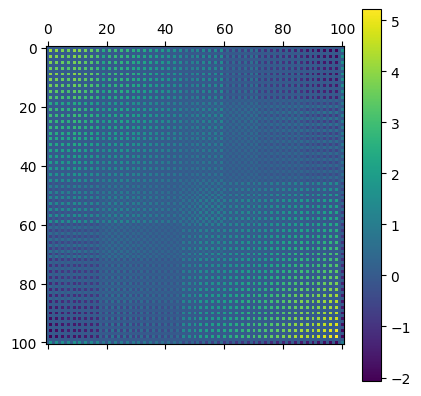

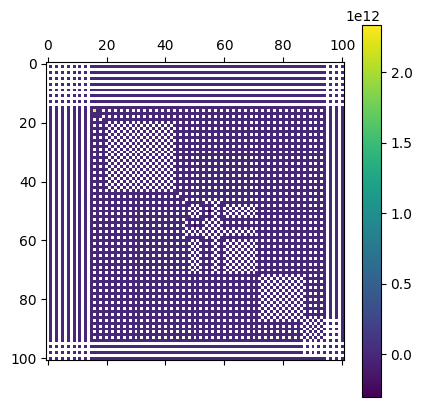

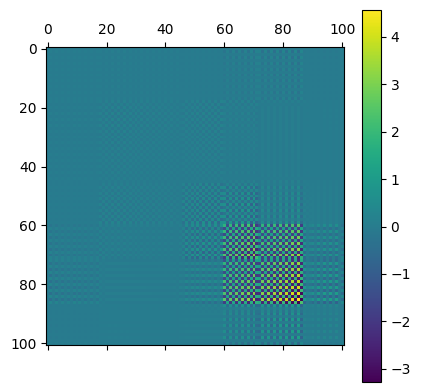

In [67]:
plt.matshow(A)
plt.colorbar()
plt.show()
plt.matshow(1/A)
plt.colorbar()
plt.show()
plt.matshow(jnp.linalg.pinv(A))
plt.colorbar()
plt.show()